In [3]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from collections import Counter
from pmareport import pmareport
import numpy as np
import matplotlib.pyplot as plt
import calendar

In [4]:
from sklearn import ensemble
from sklearn import cross_validation
from sklearn import metrics
from sklearn import linear_model

In [5]:
clinic = pmareport.Clinic()
df = clinic.df

In [6]:
df.head()

,PATIENT_ID,PATIENT_CONDITION,INSURANCE_TYPE,AGE,SEX,PROVIDER_NAME,date,sched,start,end,...,month,num_appts,appt_pos_overall,appt_pos_doctor,cond,schedd,startd,endd,arrived,since_prev_sched
0,4591553,Uncommon Cold,BlueSword/BlueDiamond,31,M,L. Jedermann,2005-01-03,1900-01-01 07:59:00,1900-01-01 08:07:00,1900-01-01 08:22:00,...,1,16,0,0,uc,479,487,502,475,NaN
1,4607440,TV Personality Disorder,Medifix,48,F,I. Petrov,2005-01-03,1900-01-01 08:15:00,1900-01-01 08:18:00,1900-01-01 08:53:00,...,1,16,1,0,tvp,495,498,533,495,NaN
2,4590430,TV Personality Disorder,Medifix,42,M,E. Medelsvensson,2005-01-03,1900-01-01 08:30:00,1900-01-01 08:42:00,1900-01-01 09:17:00,...,1,16,2,0,tvp,510,522,557,506,NaN
3,4619481,Saturday Night Fever,Self Insured,22,M,J. Smith,2005-01-03,1900-01-01 09:00:00,1900-01-01 09:11:00,1900-01-01 09:39:00,...,1,16,3,0,snf,540,551,579,543,NaN
4,4610862,Uncommon Cold,Self Insured,32,M,L. Jedermann,2005-01-03,1900-01-01 10:00:00,1900-01-01 10:00:00,1900-01-01 10:16:00,...,1,16,4,1,uc,600,600,616,596,121


In [7]:
# Get the min appointment times and the number of appointments scheduled for less
min_appt_times = df.groupby('cond').appt_time.min()
s = 0
for cond in min_appt_times.index:
    min_appt_time = min_appt_times[cond]
    data = df[df.cond == cond]
    num_appts = len(data[data.since_prev_sched < min_appt_time])
    print 'Condition: {}\n\tmin appt time: {}\n\tnum appts less: {}'.format(cond, min_appt_time, num_appts)
    s += num_appts
print s

Condition: snf
	min appt time: 13.0
	num appts less: 287
Condition: tvp
	min appt time: 29.0
	num appts less: 181
Condition: uc
	min appt time: 10.0
	num appts less: 95
563


In [9]:
# Get the number of appointments that were double- or triple-booked
df_doc_date_sched = df.groupby(['PROVIDER_NAME', 'date', 'schedd'])
df_doc_date_sched_cnt = df_doc_date_sched.count()
double_booked = df_doc_date_sched_cnt[df_doc_date_sched_cnt.PATIENT_ID == 2]
triple_booked = df_doc_date_sched_cnt[df_doc_date_sched_cnt.PATIENT_ID == 3]
len(double_booked), len(triple_booked)

(242, 7)

In [10]:
# Turn the categorical variables into ints for decision trees and one hot encoding 
def make_int(nm):
    categories = list(set(df[nm]))
    df[nm+'i'] = df[nm].apply(lambda x : categories.index(x))
for i in ['PATIENT_CONDITION', 'SEX', 'INSURANCE_TYPE', 'PROVIDER_NAME']:
    make_int(i)

In [27]:
# Make the dataset to go into the model
feat = ['AGE', 'PATIENT_CONDITIONi']
data = df[feat]

# Train/test split the dataset
train, test = cross_validation.train_test_split(df, test_size=0.1) 

In [28]:
Xtrain, ytrain = train[feat], train.appt_time
Xtest, ytest = test[feat], test.appt_time

In [51]:
# CV split the dataset
cv = cross_validation.KFold(len(train), n_folds = 10)

In [73]:
from sklearn.tree import DecisionTreeRegressor

In [81]:
# model = ensemble.RandomForestRegressor()
model = DecisionTreeRegressor(max_depth=3)

In [82]:
msel = []
for train, test in cv:
    cvXtrain = Xtrain.iloc[train]
    cvXtest = Xtrain.iloc[test]
    cvytrain = ytrain.iloc[train]
    cvytest = ytrain.iloc[test]
    model.fit(cvXtrain, cvytrain)
    pred = model.predict(cvXtest)
    mse = percent_within(y_true=cvytest, y_pred=pred, thresh=5)
    msel.append(mse)
print msel, np.mean(msel)

[93.736501079913609, 96.112311015118792, 93.722943722943725, 95.67099567099568, 94.805194805194802, 94.805194805194802, 95.238095238095227, 96.320346320346317, 94.588744588744589, 95.238095238095227] 95.0238422485


In [83]:
model.fit(Xtrain, ytrain)
pred2 = model.predict(Xtest)
percent_within(y_true=ytest, y_pred=pred2, thresh=5)

95.27145359019265

In [48]:
def percent_within(y_true, y_pred, thresh=5):
    return np.sum(np.abs(y_true - y_pred) < thresh)/float(len(y_true))*100

In [84]:
model

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=None,
           splitter='best')

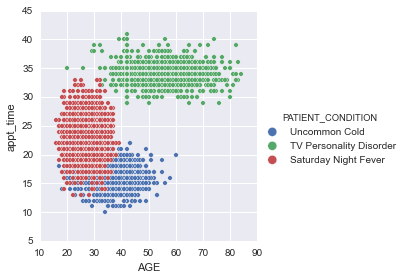

In [90]:
clinic.make_scatter()

In [108]:
def make_scatter(
        df=None,
        hue='PATIENT_CONDITION',
        size=4,
        xvar='AGE',
        yvar='appt_time',
        file_name=None
        ):
    g = sns.FacetGrid(data=df, hue=hue, size=size)
    g = g.map(plt.scatter, xvar, yvar, edgecolor='w')
    g.add_legend(fontsize=10, markerscale=2)
    plt.title('Appointment duration vs age by condition')
    plt.ylabel('min')
    plt.xlabel('')
    if file_name:
        g.savefig(file_name, bbox='tight', dpi=300)
    else:
        return g

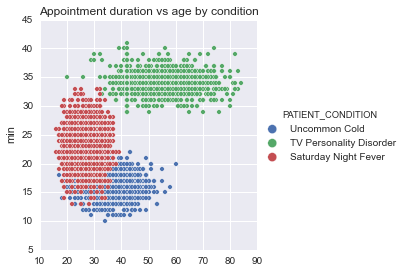

In [109]:
make_scatter(df, file_name='age_appt_cond.png')

In [110]:
Counter(df.AGE)

Counter({16: 2,
         17: 9,
         18: 24,
         19: 46,
         20: 86,
         21: 151,
         22: 152,
         23: 177,
         24: 227,
         25: 201,
         26: 225,
         27: 243,
         28: 238,
         29: 227,
         30: 230,
         31: 246,
         32: 233,
         33: 218,
         34: 181,
         35: 153,
         36: 106,
         37: 118,
         38: 93,
         39: 78,
         40: 70,
         41: 97,
         42: 731,
         43: 69,
         44: 69,
         45: 56,
         46: 51,
         47: 47,
         48: 40,
         49: 47,
         50: 39,
         51: 36,
         52: 43,
         53: 34,
         54: 37,
         55: 43,
         56: 33,
         57: 47,
         58: 39,
         59: 35,
         60: 31,
         61: 24,
         62: 33,
         63: 41,
         64: 35,
         65: 22,
         66: 26,
         67: 20,
         68: 21,
         69: 22,
         70: 15,
         71: 13,
         72: 14,
         73: 12

In [111]:
731/246.0

2.9715447154471546

In [112]:
df[df.cond == 'tvp'].groupby(['PROVIDER_NAME', 'AGE']).count().PATIENT_ID

PROVIDER_NAME     AGE
E. Medelsvensson  42     653
I. Petrov         30       1
                  32       2
                  34       1
                  36       3
                  37       1
                  38       1
                  39       3
                  41       2
                  42       4
                  43       3
                  44       6
                  45       4
                  46      10
                  47       4
                  48      12
                  49       9
                  50      14
                  51      10
                  52      14
                  53      14
                  54      13
                  55       9
                  56       9
                  57      16
                  58      14
                  59       7
                  60       6
                  61      10
                  62       7
                        ... 
N. Fulano         55      32
                  56      23
                  57 

In [113]:
653/731.0

0.893296853625171